In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import torch        
import torch.nn as nn

# from check_lang import id_to_en
from transformers import BertTokenizer, AutoModel
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

from Preprocessing import preprocess_text
from functions import plot_vector_distribution, load_data
from finetuned_pipeline import *


d:\GitHub\Jurnal-Clustering\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
# Load pre-trained IndoBERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')
model = BertClassifier(12)
model.load_state_dict(torch.load('model/finetuned_model_sinta2.pt'))

jurnal_id = 5
jurnal_type = 'finetuned_sinta'

kmeans_model,  outscoop_threshold, pca_data, X_bert, df_res = load_data(jurnal_id, jurnal_type)
predictor = ScoopPredictor(tokenizer, model, kmeans_model,  outscoop_threshold, pca_data, X_bert)

inScoop_df = df_res[df_res['Label'] == 1]
outScoop_df = df_res[df_res['Label'] == -1]

# Mendapatkan koordinat pusat cluster
centroid = kmeans_model.cluster_centers_

# Menghitung jarak antara setiap titik data dengan centroid
jarak_ke_centroid = np.sqrt(np.sum((pca_data - centroid)**2, axis=1))

# Menentukan label untuk scoop dan outscoop
scoop_labels = np.ones(len(pca_data))
scoop_labels[jarak_ke_centroid > outscoop_threshold] = -1

inScoop_df = df_res[df_res['Label'] == 1]
outScoop_df = df_res[df_res['Label'] == -1]

# plot_vector_distribution(pca_data, kmeans_model.labels_, scoop_labels)

A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Pl

d:\GitHub\Jurnal-Clustering\venv\lib\site-packages\transformers\models\bert\modeling_bert.py:439: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


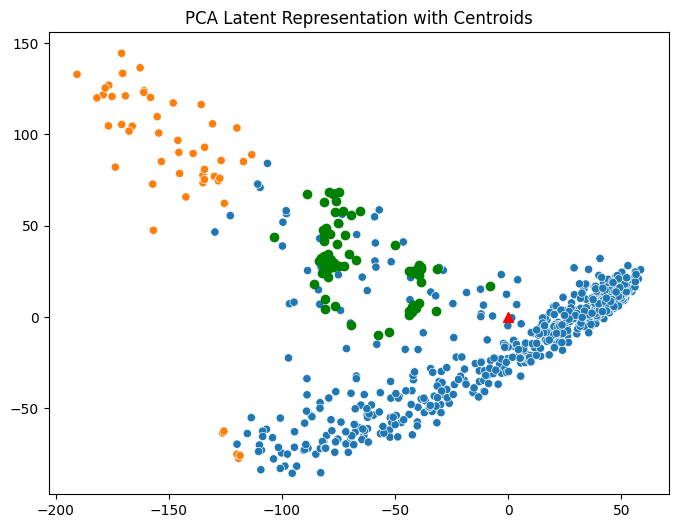

In [7]:
injected_data = pd.read_csv('data/data_sinta_cleaned.csv')
injected_data.dropna(inplace=True)

complement_journal = {
    1 : [4, 5, 7, 8, 9, 10, 11, 12],
    2 : [4, 5, 7, 8, 9, 10, 11, 12],
    3 : [4, 5, 7, 8, 9, 10, 11, 12],
    4 : [1, 2, 3, 6, 8, 10, 11],
    5 : [1, 2, 3, 6, 8, 10, 11],
    6 : [4, 5, 7, 8, 9, 10, 11, 12],
    7 : [4, 5, 8, 9, 10, 12],
    8 : [1, 2, 3, 4, 5, 6, 7, 9, 11, 12],
    9 : [1, 2, 3, 6, 8, 10, 11],
    10 : [1, 2, 3, 4, 5, 6, 7, 9, 11, 12],
    11 : [1, 2, 3, 4, 5, 6, 8, 9, 10, 12],
    12 : [1, 2, 3, 6, 8, 10, 11]
}   

new_data_pca = []
scoop_predictions = []
distances = []
test_data = injected_data[injected_data.jid.isin(complement_journal[jurnal_id])].sample(int(len(df_res) * 0.1))

for data in test_data.iloc:
    test_title = data.title
    test_abs = data.desc

    scoop_prediction, data_pca, distance = predictor.predict_scoop(test_title, test_abs)
    data_pca = np.squeeze(data_pca)

    scoop_predictions.append(scoop_prediction)
    distances.append(distance)
    new_data_pca.append(data_pca)

# scoop_prediction, new_data_pca, distance = predictor.predict_scoop(test_title, test_abs)
plot_vector_distribution(pca_data, kmeans_model.labels_, scoop_labels, np.array(new_data_pca))

In [8]:
injected_data[injected_data.jid == jurnal_id].journal.sample().values[0], test_data.journal.unique()

('JURNAL AKUNTANSI DAN KEUANGAN',
 array(['JURNAL OBSESI: JURNAL PENDIDIKAN ANAK USIA DINI',
        'JURNAL KESEHATAN MASYARAKAT', 'JURNAL KESEHATAN ANDALAS',
        'INTERNATIONAL JOURNAL OF ELEMENTARY EDUCATION',
        'JURNAL CENDEKIA : JURNAL PENDIDIKAN MATEMATIKA',
        'JURNAL PENDIDIKAN TEKNIK MESIN UNDIKSHA'], dtype=object))

In [9]:
sum_outscoop_data = np.sum([1 for predict in scoop_predictions if predict == 'out scoop'])
f'{sum_outscoop_data} outscoop out of {len(scoop_predictions)} injected data'

'0.0 outscoop out of 80 injected data'